In [ ]:
# =====================================================
# CS667 – Project 3: Anomaly Detection (GMM + Isolation Forest)
# Dataset: financial_anomaly_data (1).xlsx
# =====================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from scipy.stats import skew

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

RANDOM_STATE = 42
contamination_rate = 0.05   # assume 5% anomalies for both models


Shape of raw data: (216960, 7)

First 5 rows:


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles



Columns: ['Timestamp', 'TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']

Data types:
Timestamp           object
TransactionID       object
AccountID           object
Amount             float64
Merchant            object
TransactionType     object
Location            object
dtype: object

Missing values per column:
Timestamp          0
TransactionID      0
AccountID          0
Amount             0
Merchant           0
TransactionType    0
Location           0
dtype: int64

Numeric columns: ['Amount']

Basic statistics for numeric columns:


,Amount
count,216960.000000
mean,50090.025108
std,29097.905016
min,10.510000
25%,25061.242500
50%,50183.980000
75%,75080.460000
max,978942.260000


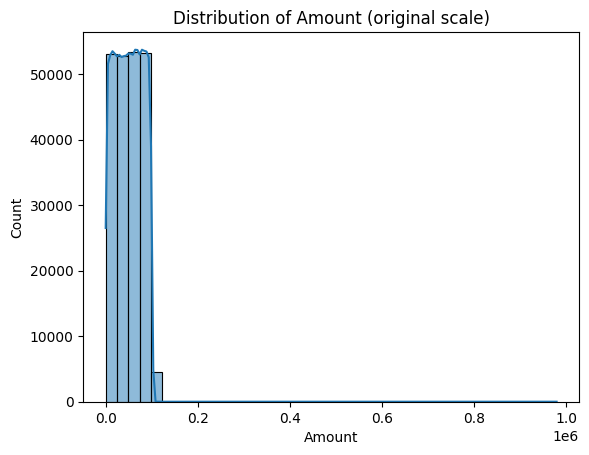


Skewness of Amount: 0.40402518724097153


In [ ]:
# =====================================================
# 1. Load & Inspect Data (3.1 Data Preparation)
# =====================================================

data_path = "financial_anomaly_data (1).xlsx"  # adjust if needed
df = pd.read_excel(data_path)

print("Shape of raw data:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nColumns:", df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

# Numeric summary stats
numeric_cols_raw = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols_raw)
if numeric_cols_raw:
    print("\nBasic statistics for numeric columns:")
    display(df[numeric_cols_raw].describe())

# Ensure Timestamp is datetime
if 'Timestamp' in df.columns:
    if not np.issubdtype(df['Timestamp'].dtype, np.datetime64):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
else:
    raise ValueError("Dataset must contain a 'Timestamp' column.")

# Plot Amount distribution
if 'Amount' in df.columns:
    plt.figure()
    sns.histplot(df['Amount'], bins=40, kde=True)
    plt.title("Distribution of Amount (original scale)")
    plt.xlabel("Amount")
    plt.ylabel("Count")
    plt.show()

    amount_skew = skew(df['Amount'].dropna())
    print("\nSkewness of Amount:", amount_skew)
else:
    raise ValueError("Dataset must contain an 'Amount' column.")


Amount skew = 0.404 -> using raw Amount as 'Amount_log'

Columns after time feature engineering:
Index(['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location', 'Amount_log', 'Hour', 'DayOfWeek', 'Day', 'Month'], dtype='object')

Sample after adding time features:


,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Amount_log,Hour,DayOfWeek,Day,Month
0,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,95071.92,8,6,1,1
1,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,15607.89,8,6,1,1
2,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,65092.34,8,6,1,1
3,TXN1438,ACC6,87.87,MerchantE,Purchase,London,87.87,8,6,1,1
4,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,716.56,8,6,1,1


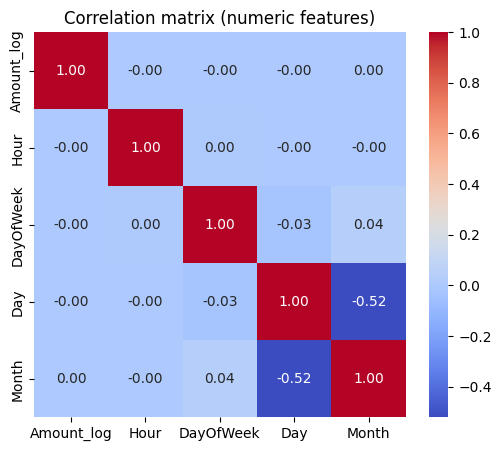

In [ ]:
# =====================================================
# 2. Feature Engineering for Time + Amount Transform
# =====================================================

# Decide whether to log-transform Amount (optional if very skewed)
if abs(amount_skew) > 1:
    df['Amount_log'] = np.log1p(df['Amount'])
    print(f"Amount skew = {amount_skew:.3f} -> using log-transform: 'Amount_log'")
else:
    df['Amount_log'] = df['Amount']
    print(f"Amount skew = {amount_skew:.3f} -> using raw Amount as 'Amount_log'")

# Time-based features from Timestamp
df['Hour']      = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.weekday  # Monday=0
df['Day']       = df['Timestamp'].dt.day
df['Month']     = df['Timestamp'].dt.month

# Drop raw Timestamp after extracting features
df = df.drop(columns=['Timestamp'])

print("\nColumns after time feature engineering:")
print(df.columns)

print("\nSample after adding time features:")
display(df.head())

# Correlation matrix for main numeric features
numeric_for_corr = ['Amount_log', 'Hour', 'DayOfWeek', 'Day', 'Month']
numeric_for_corr = [c for c in numeric_for_corr if c in df.columns]

corr = df[numeric_for_corr].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix (numeric features)")
plt.show()


In [ ]:
# =====================================================
# 3. Feature Selection & Missing Values (3.2)
# =====================================================

# Choose feature columns for modeling (no IDs)
feature_cols = [
    'AccountID',       # categorical
    'Amount_log',      # numeric
    'Merchant',        # categorical
    'TransactionType', # categorical
    'Location',        # categorical
    'Hour',            # numeric
    'DayOfWeek',       # numeric
    'Day',             # numeric
    'Month'            # numeric
]

# Check all columns exist
missing_features = [c for c in feature_cols if c not in df.columns]
if missing_features:
    raise ValueError(f"Missing columns in df needed for modeling: {missing_features}")

df_features = df[feature_cols].copy()
print("\nSelected feature columns:")
display(df_features.head())

# Identify numeric and categorical features explicitly
numeric_features = ['Amount_log', 'Hour', 'DayOfWeek', 'Day', 'Month']
categorical_features = ['AccountID', 'Merchant', 'TransactionType', 'Location']

# Handle missing values: numeric -> median, categorical -> "Missing"
for col in numeric_features:
    if df_features[col].isna().any():
        df_features[col].fillna(df_features[col].median(), inplace=True)

for col in categorical_features:
    if df_features[col].isna().any():
        df_features[col].fillna("Missing", inplace=True)

print("\nMissing values after imputation:")
print(df_features.isna().sum())



Selected feature columns:


,AccountID,Amount_log,Merchant,TransactionType,Location,Hour,DayOfWeek,Day,Month
0,ACC4,95071.92,MerchantH,Purchase,Tokyo,8,6,1,1
1,ACC10,15607.89,MerchantH,Purchase,London,8,6,1,1
2,ACC8,65092.34,MerchantE,Withdrawal,London,8,6,1,1
3,ACC6,87.87,MerchantE,Purchase,London,8,6,1,1
4,ACC6,716.56,MerchantI,Purchase,Los Angeles,8,6,1,1



Missing values after imputation:
AccountID          0
Amount_log         0
Merchant           0
TransactionType    0
Location           0
Hour               0
DayOfWeek          0
Day                0
Month              0
dtype: int64


In [ ]:
# 4. Preprocessing Pipeline (Scaling + One-Hot)

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
X_train_prepared = preprocessor.fit_transform(X_train_raw)


In [ ]:
# === Feature selection, preprocessing, and split together ===

feature_cols = [
    'AccountID', 'Amount_log', 'Merchant', 'TransactionType',
    'Location', 'Hour', 'DayOfWeek', 'Day', 'Month'
]

df_features = df[feature_cols].copy()

numeric_features = ['Amount_log', 'Hour', 'DayOfWeek', 'Day', 'Month']
categorical_features = ['AccountID', 'Merchant', 'TransactionType', 'Location']

for col in numeric_features:
    if df_features[col].isna().any():
        df_features[col].fillna(df_features[col].median(), inplace=True)

for col in categorical_features:
    if df_features[col].isna().any():
        df_features[col].fillna("Missing", inplace=True)

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train_raw, X_test_raw = train_test_split(
    df_features,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("\nTrain shape (raw):", X_train_raw.shape)
print("Test shape (raw):", X_test_raw.shape)

X_train_prepared = preprocessor.fit_transform(X_train_raw)
X_test_prepared  = preprocessor.transform(X_test_raw)

X_train = np.asarray(X_train_prepared)
X_test  = np.asarray(X_test_prepared)

print("Prepared TRAIN shape:", X_train.shape)
print("Prepared TEST shape:", X_test.shape)

feature_names = preprocessor.get_feature_names_out()



Train shape (raw): (173568, 9)
Test shape (raw): (43392, 9)
Prepared TRAIN shape: (173568, 38)
Prepared TEST shape: (43392, 38)


In [ ]:
# =====================================================
# 6. GMM – Choose k via BIC, Fit Final Model
# =====================================================

n_components_options = [2, 3, 4, 5, 6, 8, 10]
bic_scores = []

print("\n--- GMM BIC search ---")
for k in n_components_options:
    gmm_tmp = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=RANDOM_STATE
    )
    gmm_tmp.fit(X_train)
    bic = gmm_tmp.bic(X_train)
    bic_scores.append(bic)
    print(f"GMM with k={k}: BIC = {bic:.2f}")

best_k = n_components_options[int(np.argmin(bic_scores))]
print(f"\nBest k according to BIC: {best_k}")

# Fit final GMM with best_k
gmm_model = GaussianMixture(
    n_components=best_k,
    covariance_type='full',
    random_state=RANDOM_STATE,
    reg_covar=1e-6
)
gmm_model.fit(X_train)



--- GMM BIC search ---
GMM with k=2: BIC = -3531958.40
GMM with k=3: BIC = -20426755.42
GMM with k=4: BIC = -22933182.46
GMM with k=5: BIC = -23498377.72
GMM with k=6: BIC = -28294547.86
GMM with k=8: BIC = -28348181.65
GMM with k=10: BIC = -30122690.65

Best k according to BIC: 10


GaussianMixture(n_components=10, random_state=42)

In [ ]:
# =====================================================
# 7. GMM – Anomaly Scores + Thresholding
# =====================================================

# score_samples gives log-likelihood: higher = more normal
gmm_log_like_train = gmm_model.score_samples(X_train)
gmm_log_like_test  = gmm_model.score_samples(X_test)

# Define anomaly score as negative log-likelihood: higher = more anomalous
gmm_anomaly_train = -gmm_log_like_train
gmm_anomaly_test  = -gmm_log_like_test

# Threshold based on contamination: top X% most anomalous
threshold_gmm = np.quantile(gmm_anomaly_train, 1 - contamination_rate)

print(f"\n[ GMM ] Using contamination rate = {contamination_rate:.2f}")
print(f"GMM anomaly score threshold (1 - contamination quantile): {threshold_gmm:.4f}")

# 1 = anomaly, 0 = normal
y_pred_gmm_test = (gmm_anomaly_test >= threshold_gmm).astype(int)

print("\n[ GMM ] Test predictions (0=normal, 1=anomaly):")
unique, counts = np.unique(y_pred_gmm_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{'Normal' if label == 0 else 'Anomaly'} ({label}): {count}")



[ GMM ] Using contamination rate = 0.05
GMM anomaly score threshold (1 - contamination quantile): -66.0444

[ GMM ] Test predictions (0=normal, 1=anomaly):
Normal (0): 41183
Anomaly (1): 2209


In [ ]:
# =====================================================
# 8. Isolation Forest – Model, Scores, Predictions
# =====================================================

iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=contamination_rate,
    max_features=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_forest.fit(X_train)

# score_samples: higher = more normal
if_score_train = iso_forest.score_samples(X_train)
if_score_test  = iso_forest.score_samples(X_test)

# Define anomaly score as negative score_samples: higher = more anomalous
if_anomaly_train = -if_score_train
if_anomaly_test  = -if_score_test

# Built-in predict: 1 = normal, -1 = anomaly
if_pred_raw = iso_forest.predict(X_test)
y_pred_if_test = np.where(if_pred_raw == -1, 1, 0)  # 1=anomaly, 0=normal

print("\n[ Isolation Forest ] Test predictions (0=normal, 1=anomaly):")
unique, counts = np.unique(y_pred_if_test, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{'Normal' if label == 0 else 'Anomaly'} ({label}): {count}")



[ Isolation Forest ] Test predictions (0=normal, 1=anomaly):
Normal (0): 41259
Anomaly (1): 2133


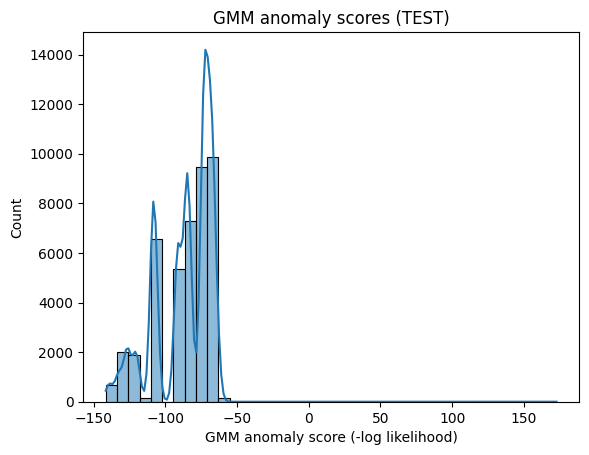

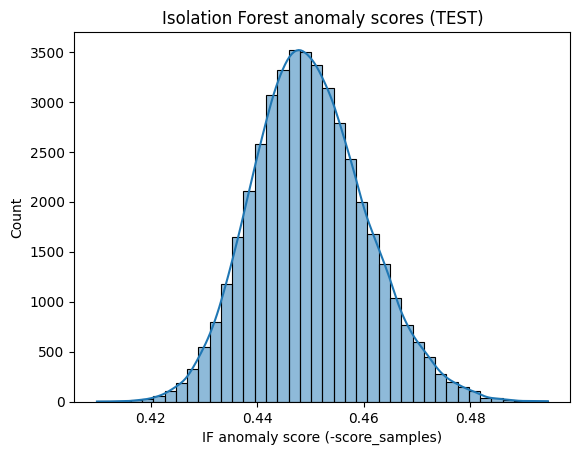

In [ ]:
# =====================================================
# 9. Score Distributions & Visualization (3.4)
# =====================================================

plt.figure()
sns.histplot(gmm_anomaly_test, bins=40, kde=True)
plt.title("GMM anomaly scores (TEST)")
plt.xlabel("GMM anomaly score (-log likelihood)")
plt.ylabel("Count")
plt.show()

plt.figure()
sns.histplot(if_anomaly_test, bins=40, kde=True)
plt.title("Isolation Forest anomaly scores (TEST)")
plt.xlabel("IF anomaly score (-score_samples)")
plt.ylabel("Count")
plt.show()


In [ ]:
# =====================================================
# 10. Top-k Most Anomalous Transactions (3.4 / 3.5)
# =====================================================

k = 10

X_test_with_index = X_test_raw.reset_index()  # 'index' = original df index

# ---- GMM anomalies ----
gmm_test_df = pd.DataFrame({
    "orig_index": X_test_with_index["index"],
    "gmm_anomaly_score": gmm_anomaly_test,
    "gmm_is_anomaly": y_pred_gmm_test
})

gmm_top = gmm_test_df.sort_values(
    by="gmm_anomaly_score", ascending=False
).head(k)

print(f"\nTop {k} GMM anomalies (highest anomaly scores):")
display(gmm_top)

print("\nOriginal rows for top GMM anomalies:")
display(df.loc[gmm_top["orig_index"]])

# ---- Isolation Forest anomalies ----
if_test_df = pd.DataFrame({
    "orig_index": X_test_with_index["index"],
    "if_anomaly_score": if_anomaly_test,
    "if_is_anomaly": y_pred_if_test
})

if_top = if_test_df.sort_values(
    by="if_anomaly_score", ascending=False
).head(k)

print(f"\nTop {k} Isolation Forest anomalies (highest anomaly scores):")
display(if_top)

print("\nOriginal rows for top IF anomalies:")
display(df.loc[if_top["orig_index"]])



Top 10 GMM anomalies (highest anomaly scores):


,orig_index,gmm_anomaly_score,gmm_is_anomaly
6483,3448,172.839890,1
11837,145053,-60.323636,1
40586,145022,-60.510965,1
13028,146135,-60.836041,1
5753,795,-60.846656,1
29060,44351,-61.009314,1
7030,146231,-61.014820,1
20794,101269,-61.066471,1
25495,44321,-61.294760,1
9430,718,-61.395188,1



Original rows for top GMM anomalies:


,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Amount_log,Hour,DayOfWeek,Day,Month
3448,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo,712076.97,17,2,1,3
145053,TXN1761,ACC11,9070.10,MerchantH,Withdrawal,San Francisco,9070.10,1,0,4,12
145022,TXN1836,ACC4,95334.25,MerchantH,Withdrawal,Tokyo,95334.25,1,0,4,12
146135,TXN1572,ACC11,5268.63,MerchantH,Transfer,London,5268.63,19,0,4,12
795,TXN1457,ACC4,3903.41,MerchantJ,Transfer,Los Angeles,3903.41,21,6,1,1
44351,TXN489,ACC11,95148.63,MerchantH,Transfer,London,95148.63,3,0,2,1
146231,TXN250,ACC4,86855.01,MerchantH,Purchase,San Francisco,86855.01,21,0,4,12
101269,TXN1780,ACC11,423.15,MerchantH,Withdrawal,San Francisco,423.15,15,6,3,12
44321,TXN1139,ACC4,89374.03,MerchantJ,Transfer,Tokyo,89374.03,2,0,2,1
718,TXN1161,ACC4,93965.75,MerchantJ,Purchase,Tokyo,93965.75,19,6,1,1



Top 10 Isolation Forest anomalies (highest anomaly scores):


,orig_index,if_anomaly_score,if_is_anomaly
39497,16616,0.494561,1
6158,15414,0.494333,1
34059,16728,0.494035,1
30389,145278,0.493878,1
30625,58644,0.493772,1
36690,16765,0.493103,1
11837,145053,0.492949,1
38709,101720,0.491485,1
25371,101589,0.491441,1
18715,94371,0.491396,1



Original rows for top IF anomalies:


,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Amount_log,Hour,DayOfWeek,Day,Month
16616,TXN119,ACC2,87773.55,MerchantB,Purchase,New York,87773.55,20,4,1,12
15414,TXN1006,ACC11,90664.93,MerchantC,Purchase,San Francisco,90664.93,0,4,1,12
16728,TXN1538,ACC10,85011.32,MerchantC,Withdrawal,Tokyo,85011.32,22,4,1,12
145278,TXN412,ACC10,79.36,MerchantC,Transfer,Tokyo,79.36,5,0,4,12
58644,TXN785,ACC15,3335.54,MerchantH,Withdrawal,Los Angeles,3335.54,1,3,2,11
16765,TXN1639,ACC11,9131.30,MerchantB,Purchase,San Francisco,9131.30,23,4,1,12
145053,TXN1761,ACC11,9070.10,MerchantH,Withdrawal,San Francisco,9070.10,1,0,4,12
101720,TXN1169,ACC4,97051.61,MerchantC,Transfer,Tokyo,97051.61,23,6,3,12
101589,TXN608,ACC5,96601.44,MerchantB,Purchase,London,96601.44,21,6,3,12
94371,TXN279,ACC11,13593.90,MerchantC,Transfer,Tokyo,13593.90,20,0,3,7


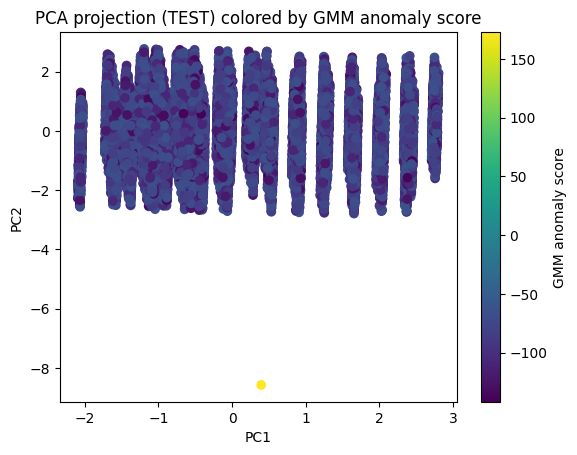

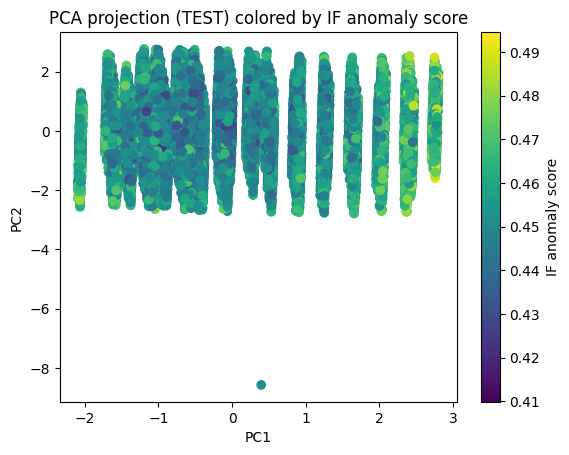

In [ ]:
# =====================================================
# 11. 2D PCA Visualization Colored by Anomaly Scores (3.5)
# =====================================================

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_pca = pca.fit_transform(X_test)

plt.figure()
plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=gmm_anomaly_test,
    cmap="viridis"
)
plt.colorbar(label="GMM anomaly score")
plt.title("PCA projection (TEST) colored by GMM anomaly score")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure()
plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=if_anomaly_test,
    cmap="viridis"
)
plt.colorbar(label="IF anomaly score")
plt.title("PCA projection (TEST) colored by IF anomaly score")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



GMM mixture weights (sum to 1):
[0.23342436 0.05256729 0.02017077 0.03314551 0.03928143 0.01314758
 0.21360504 0.16658025 0.1010094  0.12706835]

GMM means shape (components x features):
(10, 38)

Component membership counts on TRAIN:
Component 0: 40515 samples
Component 1: 9124 samples
Component 2: 3501 samples
Component 3: 5753 samples
Component 4: 6818 samples
Component 5: 2282 samples
Component 6: 37075 samples
Component 7: 28913 samples
Component 8: 17532 samples
Component 9: 22055 samples


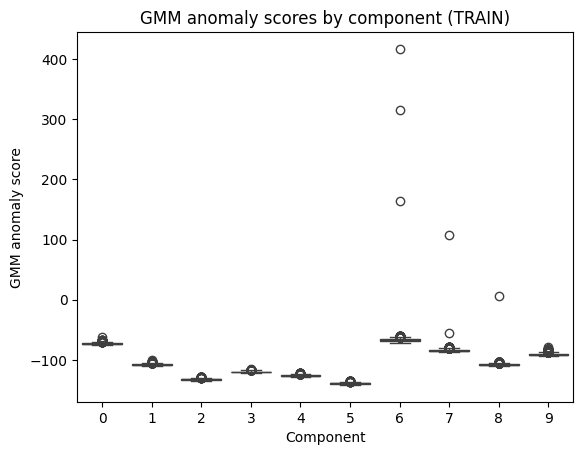

In [ ]:
# =====================================================
# 12. GMM Component Interpretation (3.5)
# =====================================================

print("\nGMM mixture weights (sum to 1):")
print(gmm_model.weights_)

print("\nGMM means shape (components x features):")
print(gmm_model.means_.shape)

train_components = gmm_model.predict(X_train)
unique_comp, comp_counts = np.unique(train_components, return_counts=True)

print("\nComponent membership counts on TRAIN:")
for c, cnt in zip(unique_comp, comp_counts):
    print(f"Component {c}: {cnt} samples")

plt.figure()
sns.boxplot(x=train_components, y=gmm_anomaly_train)
plt.title("GMM anomaly scores by component (TRAIN)")
plt.xlabel("Component")
plt.ylabel("GMM anomaly score")
plt.show()


In [ ]:
# =====================================================
# 13. Permutation-based Feature Importance (Isolation Forest) (3.5)
# =====================================================

# Measure how much anomaly scores change when each feature is shuffled
baseline_scores_if = if_anomaly_test.copy()  # anomaly scores on TEST
rng = np.random.RandomState(RANDOM_STATE)

importances = []

for j, fname in enumerate(feature_names):
    X_perm = X_test.copy()
    col = X_perm[:, j].copy()
    rng.shuffle(col)
    X_perm[:, j] = col

    perm_scores = -iso_forest.score_samples(X_perm)  # recompute anomaly scores
    importance_j = np.mean(np.abs(perm_scores - baseline_scores_if))
    importances.append(importance_j)

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nPermutation-based feature importance (Isolation Forest):")
display(fi_df.head(20))



Permutation-based feature importance (Isolation Forest):


,feature,importance
37,cat__Location_Tokyo,0.006038
27,cat__Merchant_MerchantH,0.005808
21,cat__Merchant_MerchantB,0.005775
34,cat__Location_Los Angeles,0.005748
22,cat__Merchant_MerchantC,0.005475
7,cat__AccountID_ACC11,0.005338
23,cat__Merchant_MerchantD,0.005312
36,cat__Location_San Francisco,0.005120
28,cat__Merchant_MerchantI,0.004968
33,cat__Location_London,0.004935


In [ ]:
# =====================================================
# 14. Combined results table (GMM + IF for TEST)
# =====================================================

# Rebuild X_test_with_index if needed
X_test_with_index = X_test_raw.reset_index()  # 'index' = original df index

results_test = pd.DataFrame({
    "orig_index": X_test_with_index["index"],
    "gmm_anomaly_score": gmm_anomaly_test,
    "gmm_is_anomaly": y_pred_gmm_test,
    "if_anomaly_score": if_anomaly_test,
    "if_is_anomaly": y_pred_if_test
})

# Flags
results_test["any_anomaly"] = np.where(
    (results_test["gmm_is_anomaly"] == 1) | (results_test["if_is_anomaly"] == 1),
    1, 0
)
results_test["both_anomaly"] = np.where(
    (results_test["gmm_is_anomaly"] == 1) & (results_test["if_is_anomaly"] == 1),
    1, 0
)

print("Combined anomaly flags (GMM vs IF) on TEST:")
display(results_test.head())

print("\nCounts by model agreement:")
print(results_test[["gmm_is_anomaly", "if_is_anomaly"]].value_counts())


Combined anomaly flags (GMM vs IF) on TEST:


,orig_index,gmm_anomaly_score,gmm_is_anomaly,if_anomaly_score,if_is_anomaly,any_anomaly,both_anomaly
0,137545,-64.709599,1,0.447085,0,1,0
1,146133,-87.733440,0,0.454563,0,0,0
2,30068,-67.989441,0,0.455393,0,0,0
3,35994,-132.698097,0,0.453486,0,0,0
4,153731,-85.498800,0,0.453591,0,0,0



Counts by model agreement:
gmm_is_anomaly  if_is_anomaly
0               0                39345
1               0                 1914
0               1                 1838
1               1                  295
Name: count, dtype: int64


In [ ]:
# =====================================================
# 15. Overlap summary between GMM and Isolation Forest
# =====================================================

total = len(results_test)

gmm_only = ((results_test["gmm_is_anomaly"] == 1) & (results_test["if_is_anomaly"] == 0)).sum()
if_only  = ((results_test["gmm_is_anomaly"] == 0) & (results_test["if_is_anomaly"] == 1)).sum()
both     = (results_test["both_anomaly"] == 1).sum()
none     = ((results_test["gmm_is_anomaly"] == 0) & (results_test["if_is_anomaly"] == 0)).sum()

print("=== Anomaly flag overlap (TEST set) ===")
print(f"Total test points: {total}")
print(f"GMM only anomalies:       {gmm_only}")
print(f"IF only anomalies:        {if_only}")
print(f"Both GMM & IF anomalies:  {both}")
print(f"Flagged by neither:       {none}")


=== Anomaly flag overlap (TEST set) ===
Total test points: 43392
GMM only anomalies:       1914
IF only anomalies:        1838
Both GMM & IF anomalies:  295
Flagged by neither:       39345


In [ ]:
# =====================================================
# 16. Attach original transaction info and describe groups
# =====================================================

# Join combined results back to original df for TEST
test_full = results_test.merge(
    df.reset_index().rename(columns={"index": "orig_index_df"}),
    left_on="orig_index",
    right_on="orig_index_df",
    how="left"
).drop(columns=["orig_index_df"])

print("Test set with original transaction info and anomaly flags:")
display(test_full.head())

# Split into groups
gmm_norm = test_full[test_full["gmm_is_anomaly"] == 0]
gmm_anom = test_full[test_full["gmm_is_anomaly"] == 1]

if_norm = test_full[test_full["if_is_anomaly"] == 0]
if_anom = test_full[test_full["if_is_anomaly"] == 1]

print("\n=== GMM: Amount summary (normal vs anomaly) ===")
print("Normal:\n", gmm_norm["Amount"].describe())
print("\nAnomaly:\n", gmm_anom["Amount"].describe())

print("\n=== Isolation Forest: Amount summary (normal vs anomaly) ===")
print("Normal:\n", if_norm["Amount"].describe())
print("\nAnomaly:\n", if_anom["Amount"].describe())


Test set with original transaction info and anomaly flags:


,orig_index,gmm_anomaly_score,gmm_is_anomaly,if_anomaly_score,if_is_anomaly,any_anomaly,both_anomaly,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Amount_log,Hour,DayOfWeek,Day,Month
0,137545,-64.709599,1,0.447085,0,1,0,TXN1526,ACC4,68834.17,MerchantJ,Withdrawal,San Francisco,68834.17,20,6,4,6
1,146133,-87.733440,0,0.454563,0,0,0,TXN1380,ACC7,90209.08,MerchantJ,Purchase,San Francisco,90209.08,19,0,4,12
2,30068,-67.989441,0,0.455393,0,0,0,TXN277,ACC5,60098.35,MerchantC,Purchase,San Francisco,60098.35,5,6,22,1
3,35994,-132.698097,0,0.453486,0,0,0,TXN1891,ACC10,94147.41,MerchantA,Purchase,Los Angeles,94147.41,7,3,26,1
4,153731,-85.498800,0,0.453591,0,0,0,TXN1945,ACC4,67429.66,MerchantG,Withdrawal,Tokyo,67429.66,2,1,18,4



=== GMM: Amount summary (normal vs anomaly) ===
Normal:
 count     41183.000000
mean      50296.533065
std       28640.391480
min          10.700000
25%       25726.965000
50%       50449.120000
75%       74958.700000
max      223542.640000
Name: Amount, dtype: float64

Anomaly:
 count      2209.00000
mean      49893.79904
std       34866.32718
min          25.34000
25%       19638.10000
50%       49602.79000
75%       80078.58000
max      712076.97000
Name: Amount, dtype: float64

=== Isolation Forest: Amount summary (normal vs anomaly) ===
Normal:
 count     41259.000000
mean      50371.374857
std       28727.494260
min          10.700000
25%       25958.430000
50%       50492.390000
75%       74892.455000
max      712076.970000
Name: Amount, dtype: float64

Anomaly:
 count     2133.000000
mean     48431.771238
std      33610.073264
min         28.600000
25%      14491.410000
50%      47970.690000
75%      81973.350000
max      99964.470000
Name: Amount, dtype: float64


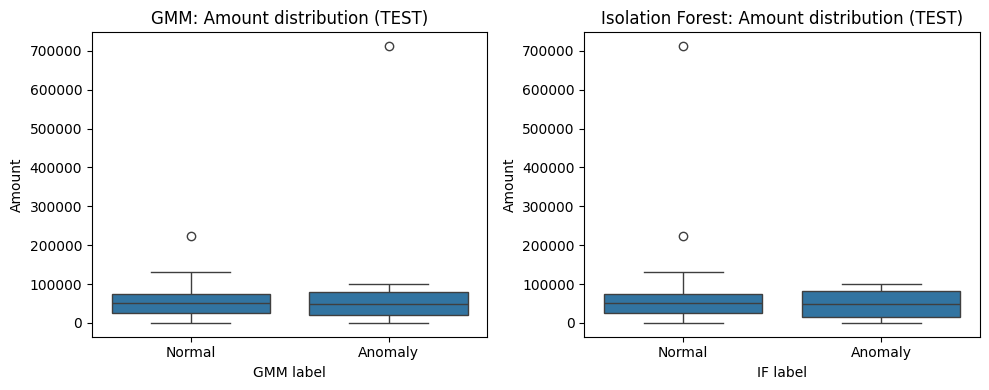

In [ ]:
# =====================================================
# 17. Boxplots: Amount for normal vs anomaly (GMM & IF)
# =====================================================

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(
    data=test_full,
    x="gmm_is_anomaly",
    y="Amount"
)
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.title("GMM: Amount distribution (TEST)")
plt.xlabel("GMM label")
plt.ylabel("Amount")

plt.subplot(1, 2, 2)
sns.boxplot(
    data=test_full,
    x="if_is_anomaly",
    y="Amount"
)
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.title("Isolation Forest: Amount distribution (TEST)")
plt.xlabel("IF label")
plt.ylabel("Amount")

plt.tight_layout()
plt.show()


In [ ]:
# =====================================================
# 18. Anomaly rate by Merchant and Location
# =====================================================

def anomaly_rate_by_col(df_in, label_col, group_col):
    grp = df_in.groupby(group_col)[label_col].agg(
        total="count",
        anomalies="sum"
    )
    grp["anomaly_rate"] = grp["anomalies"] / grp["total"]
    return grp.sort_values("anomaly_rate", ascending=False)

print("\n=== GMM: anomaly rate by Merchant ===")
display(anomaly_rate_by_col(test_full, "gmm_is_anomaly", "Merchant").head(10))

print("\n=== GMM: anomaly rate by Location ===")
display(anomaly_rate_by_col(test_full, "gmm_is_anomaly", "Location").head(10))

print("\n=== IF: anomaly rate by Merchant ===")
display(anomaly_rate_by_col(test_full, "if_is_anomaly", "Merchant").head(10))

print("\n=== IF: anomaly rate by Location ===")
display(anomaly_rate_by_col(test_full, "if_is_anomaly", "Location").head(10))



=== GMM: anomaly rate by Merchant ===


,total,anomalies,anomaly_rate
Merchant,,,
MerchantH,4252,543,0.127705
MerchantJ,4329,536,0.123816
MerchantF,4544,428,0.094190
MerchantI,4280,348,0.081308
MerchantA,4346,68,0.015647
MerchantC,4283,63,0.014709
MerchantG,4364,62,0.014207
MerchantE,4229,57,0.013478
MerchantD,4361,54,0.012382



=== GMM: anomaly rate by Location ===


,total,anomalies,anomaly_rate
Location,,,
London,8770,463,0.052794
San Francisco,8805,463,0.052584
Tokyo,8581,442,0.051509
New York,8554,418,0.048866
Los Angeles,8682,423,0.048721



=== IF: anomaly rate by Merchant ===


,total,anomalies,anomaly_rate
Merchant,,,
MerchantH,4252,380,0.089370
MerchantB,4404,384,0.087193
MerchantC,4283,350,0.081718
MerchantD,4361,238,0.054575
MerchantI,4280,197,0.046028
MerchantF,4544,159,0.034991
MerchantA,4346,141,0.032444
MerchantG,4364,134,0.030706
MerchantE,4229,94,0.022227



=== IF: anomaly rate by Location ===


,total,anomalies,anomaly_rate
Location,,,
Tokyo,8581,614,0.071553
Los Angeles,8682,489,0.056323
New York,8554,370,0.043255
San Francisco,8805,367,0.041681
London,8770,293,0.033409


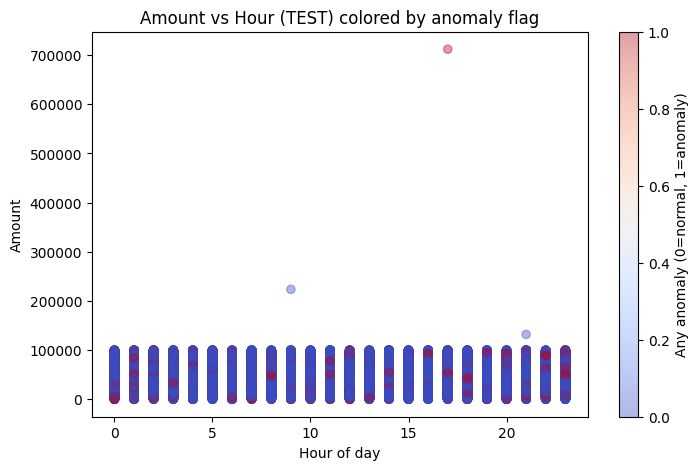

In [ ]:
# =====================================================
# 19. Scatter: Amount vs Hour colored by anomaly
# =====================================================

# any_anomaly already defined in results_test; ensure it's in test_full
if "any_anomaly" not in test_full.columns:
    test_full["any_anomaly"] = np.where(
        (test_full["gmm_is_anomaly"] == 1) | (test_full["if_is_anomaly"] == 1),
        1, 0
    )

plt.figure(figsize=(8, 5))
scatter = plt.scatter(
    test_full["Hour"],
    test_full["Amount"],
    c=test_full["any_anomaly"],
    cmap="coolwarm",
    alpha=0.4
)
plt.colorbar(scatter, label="Any anomaly (0=normal, 1=anomaly)")
plt.title("Amount vs Hour (TEST) colored by anomaly flag")
plt.xlabel("Hour of day")
plt.ylabel("Amount")
plt.show()


In [ ]:
# === Combined results with original transaction info ===

# Rebuild X_test_with_index if needed
X_test_with_index = X_test_raw.reset_index()  # 'index' is original df index

results_test = pd.DataFrame({
    "orig_index": X_test_with_index["index"],
    "gmm_anomaly_score": gmm_anomaly_test,
    "gmm_is_anomaly": y_pred_gmm_test,
    "if_anomaly_score": if_anomaly_test,
    "if_is_anomaly": y_pred_if_test
})

# Flags
results_test["any_anomaly"] = np.where(
    (results_test["gmm_is_anomaly"] == 1) | (results_test["if_is_anomaly"] == 1),
    1, 0
)

# Attach back original columns (Amount, Merchant, Location, etc.)
test_full = results_test.merge(
    df.reset_index().rename(columns={"index": "orig_index_df"}),
    left_on="orig_index",
    right_on="orig_index_df",
    how="left"
).drop(columns=["orig_index_df"])

print("Test set with original transaction info and anomaly flags:")
display(test_full.head())


Test set with original transaction info and anomaly flags:


,orig_index,gmm_anomaly_score,gmm_is_anomaly,if_anomaly_score,if_is_anomaly,any_anomaly,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Amount_log,Hour,DayOfWeek,Day,Month
0,137545,-64.709599,1,0.447085,0,1,TXN1526,ACC4,68834.17,MerchantJ,Withdrawal,San Francisco,68834.17,20,6,4,6
1,146133,-87.733440,0,0.454563,0,0,TXN1380,ACC7,90209.08,MerchantJ,Purchase,San Francisco,90209.08,19,0,4,12
2,30068,-67.989441,0,0.455393,0,0,TXN277,ACC5,60098.35,MerchantC,Purchase,San Francisco,60098.35,5,6,22,1
3,35994,-132.698097,0,0.453486,0,0,TXN1891,ACC10,94147.41,MerchantA,Purchase,Los Angeles,94147.41,7,3,26,1
4,153731,-85.498800,0,0.453591,0,0,TXN1945,ACC4,67429.66,MerchantG,Withdrawal,Tokyo,67429.66,2,1,18,4


GMM: anomaly rate by Merchant


,total,anomalies,anomaly_rate
Merchant,,,
MerchantH,4252,543,0.127705
MerchantJ,4329,536,0.123816
MerchantF,4544,428,0.094190
MerchantI,4280,348,0.081308
MerchantA,4346,68,0.015647
MerchantC,4283,63,0.014709
MerchantG,4364,62,0.014207
MerchantE,4229,57,0.013478
MerchantD,4361,54,0.012382


GMM: anomaly rate by Location


,total,anomalies,anomaly_rate
Location,,,
London,8770,463,0.052794
San Francisco,8805,463,0.052584
Tokyo,8581,442,0.051509
New York,8554,418,0.048866
Los Angeles,8682,423,0.048721


IF: anomaly rate by Merchant


,total,anomalies,anomaly_rate
Merchant,,,
MerchantH,4252,380,0.089370
MerchantB,4404,384,0.087193
MerchantC,4283,350,0.081718
MerchantD,4361,238,0.054575
MerchantI,4280,197,0.046028
MerchantF,4544,159,0.034991
MerchantA,4346,141,0.032444
MerchantG,4364,134,0.030706
MerchantE,4229,94,0.022227


IF: anomaly rate by Location


,total,anomalies,anomaly_rate
Location,,,
Tokyo,8581,614,0.071553
Los Angeles,8682,489,0.056323
New York,8554,370,0.043255
San Francisco,8805,367,0.041681
London,8770,293,0.033409


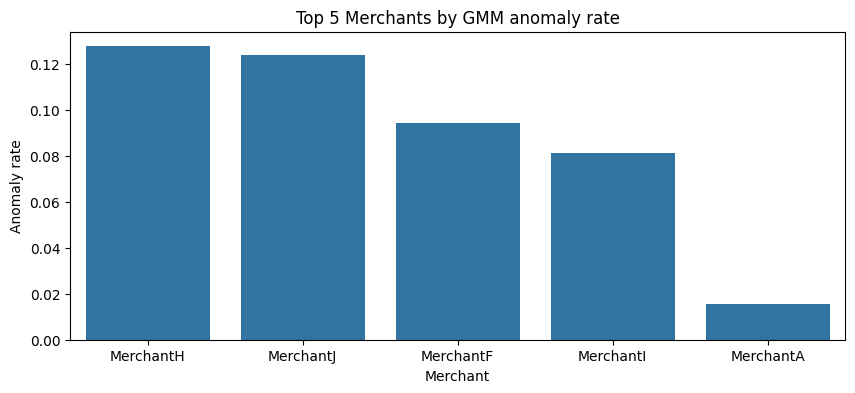

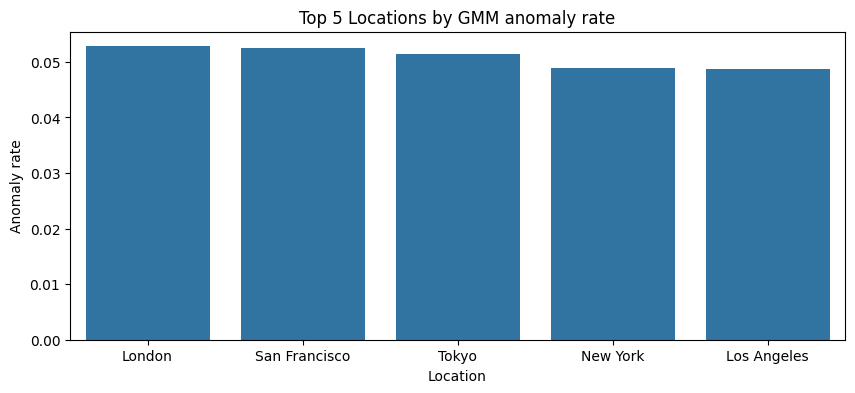

In [ ]:
# Helper to compute anomaly rate for a categorical column
def anomaly_rate_by_col(df_in, label_col, group_col):
    grp = df_in.groupby(group_col)[label_col].agg(
        total="count",
        anomalies="sum"
    )
    grp["anomaly_rate"] = grp["anomalies"] / grp["total"]
    return grp.sort_values("anomaly_rate", ascending=False)

# GMM: anomaly rate by Merchant
gmm_merchant = anomaly_rate_by_col(test_full, "gmm_is_anomaly", "Merchant")
gmm_location = anomaly_rate_by_col(test_full, "gmm_is_anomaly", "Location")

# IF: anomaly rate by Merchant
if_merchant = anomaly_rate_by_col(test_full, "if_is_anomaly", "Merchant")
if_location = anomaly_rate_by_col(test_full, "if_is_anomaly", "Location")

print("GMM: anomaly rate by Merchant")
display(gmm_merchant)

print("GMM: anomaly rate by Location")
display(gmm_location)

print("IF: anomaly rate by Merchant")
display(if_merchant)

print("IF: anomaly rate by Location")
display(if_location)

# Plot a few top ones as bar charts
plt.figure(figsize=(10, 4))
sns.barplot(
    data=gmm_merchant.reset_index().head(5),
    x="Merchant",
    y="anomaly_rate"
)
plt.title("Top 5 Merchants by GMM anomaly rate")
plt.ylabel("Anomaly rate")
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(
    data=gmm_location.reset_index().head(5),
    x="Location",
    y="anomaly_rate"
)
plt.title("Top 5 Locations by GMM anomaly rate")
plt.ylabel("Anomaly rate")
plt.show()


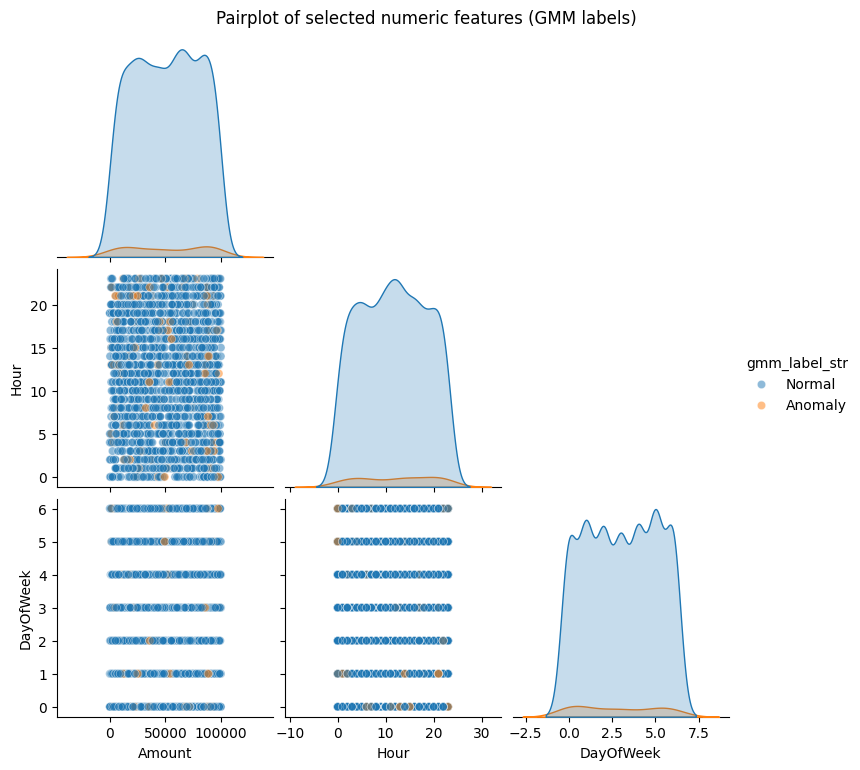

In [ ]:
# Take a small sample for pairplot (e.g., 2000 rows to avoid being too slow)
sample_vis = test_full.sample(n=2000, random_state=RANDOM_STATE)

sns.pairplot(
    sample_vis,
    vars=["Amount", "Hour", "DayOfWeek"],
    hue="gmm_label_str",
    corner=True,
    plot_kws={"alpha": 0.5}
)
plt.suptitle("Pairplot of selected numeric features (GMM labels)", y=1.02)
plt.show()


In [ ]:
!pip install plotly


In [ ]:
import plotly.express as px

fig = px.scatter(
    test_full.sample(5000, random_state=RANDOM_STATE),
    x="Hour",
    y="Amount",
    color="gmm_label_str",
    hover_data=["Merchant", "Location", "TransactionType", "AccountID"],
    title="Interactive: Amount vs Hour colored by GMM anomaly label"
)
fig.show()
